# Pose Estimation

In this notebook, we will create a yoga pose classifier. This take an input image and find the best match from the available yoga pose information we have. The classifier will extact the images key-point's and find the closest matching pose according to similarity metrics. 

Current avaialble yoga poses:
- Camel
- Crescent Lunge
- Downward Dog
- Extended Triangle
- Warrior

## Todo:
- create img df + KP info storage (HOW?)

## TODO: Rule based decision

Next up - create a dataset of up to 10 famous yoga poses with images (https://www.yogajournal.com/poses/10-yoga-poses-do-every-day/)

Get random input image and compare it with a single image?? (maybe us multiple here and take an average of comparissons)
- To output whether the input pose is the same as one of our classified poses by closest match and metric threshold matching

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import os
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from dtaidistance import dtw
from os import listdir
from os.path import isfile, join
import itertools

In [3]:
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic

POSE_LANDMARKS = [m.name for m in mp_pose.PoseLandmark]
index_to_body_mapping = {i:body_part for i, body_part in enumerate(POSE_LANDMARKS)}

In [4]:

# with mp_holistic.Holistic(
#     static_image_mode=False,
#     model_complexity=1, # [0, 1, 2] - increases accuracy and latency
#     smooth_landmarks=True,
#     enable_segmentation=False,
#     smooth_segmentation=False,
#     refine_face_landmarks=False,
#     min_detection_confidence=0.5,
#     min_tracking_confidence=0.5
# ) as holistic_pose:

#     while video.isOpened():

#         # Capture the video frame by frame
#         ret, frame = video.read()

        
#         # Detect stuff and render to output frame
#         # CV automatically parsed images in BGR format however we need it in RGB format
#         img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         # Added for performance gains
#         img_rgb.flags.writeable = False
        
#         # Estimate Pose
#         results = holistic_pose.process(img_rgb)
                
#         # Recolor back to BGR
#         img_rgb.flags.writeable = True
#         image = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        
#         # Extract Landmarks
#         try:
#              # Draw landmark annotation on the image.
#             body_pose_landmarks = results.pose_landmarks
#             # face_landmarks = results.face_landmarks
#             # print("landmarks", landmarks)
#             # print("face_landmarks", face_landmarks)
            
#             # mp_drawing.draw_landmarks(
#             #     image,
#             #     face_landmarks,
#             #     mp_holistic.FACEMESH_CONTOURS,
#             #     landmark_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style(),
#             #     connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style()
#             # )

#             mp_drawing.draw_landmarks(
#                 image,
#                 body_pose_landmarks,
#                 mp_holistic.POSE_CONNECTIONS,
#                 landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style(),
#             )

    
#             # Get Coordinates            
#             # cv2.putText(
#             #     image, 
#             #     f"{angle_degrees:.3f}",
#             #     position,
#             #     fontFace=cv2.FONT_HERSHEY_SIMPLEX,
#             #     fontScale=0.5,
#             #     color=(255, 255, 255), 
#             #     thickness=2,
#             #     lineType=cv2.LINE_AA
#             # )
            
#         except:
#             pass
        
        
        
#         # Display on image feed
#         cv2.imshow('Holistic Pose Estimation Feed', image)



#         # Press 'q' to close the videp
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

        
#     # After the loop release the cap object
#     video.release()
#     # Destroy all the windows
#     cv2.destroyAllWindows()


## Apply Pose estimation model  to static picture and plot in 3D

In [11]:
elevation = 10
azimuth =  10

    
def calc_angle_in_3d_space(a, b, c):  
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    v1 = np.array([ a[0] - b[0], a[1] - b[1], a[2] - b[2] ])
    v2 = np.array([ c[0] - b[0], c[1] - b[1], c[2] - b[2] ])

    v1mag = np.sqrt([ v1[0] * v1[0] + v1[1] * v1[1] + v1[2] * v1[2] ])
    v1norm = np.array([ v1[0] / v1mag, v1[1] / v1mag, v1[2] / v1mag ])

    v2mag = np.sqrt(v2[0] * v2[0] + v2[1] * v2[1] + v2[2] * v2[2])
    v2norm = np.array([ v2[0] / v2mag, v2[1] / v2mag, v2[2] / v2mag ])
    res = v1norm[0] * v2norm[0] + v1norm[1] * v2norm[1] + v1norm[2] * v2norm[2]
    angle_rad = np.arccos(res)
    
    if angle_rad > np.pi:
        angle_rad = 2*np.pi - angle_rad

    return math.degrees(angle_rad)


def calc_angle_in_2d_space(a, b, c):  
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    radians = np.abs(radians)
    
    if radians > np.pi:
        angle_rad = 2*np.pi - angle_rad

    return np.degrees(radians)


def get_coords_from_landmark(landmark):
    return (landmark.x, landmark.y)


def _normalize_color(color):
     return tuple(v / 255. for v in color)

def custom_plot_landmarks(
    landmark_list,
    ax,
    add_connections: bool = True,
    landmark_drawing_spec: mp_drawing.DrawingSpec = mp_drawing.DrawingSpec(color=mp_drawing.RED_COLOR, thickness=5),
    connection_drawing_spec: mp_drawing.DrawingSpec = mp_drawing.DrawingSpec(color=mp_drawing.BLACK_COLOR, thickness=5),
    visibility_threshold=0.5,
    presence_threshold=0.5,
):
    """Plot the landmarks and the connections in matplotlib 3d.
    Args:
    landmark_list: A normalized landmark list proto message to be plotted.
    connections: A list of landmark index tuples that specifies how landmarks to
      be connected.
    landmark_drawing_spec: A DrawingSpec object that specifies the landmarks'
      drawing settings such as color and line thickness.
    connection_drawing_spec: A DrawingSpec object that specifies the
      connections' drawing settings such as color and line thickness.
    elevation: The elevation from which to view the plot.
    azimuth: the azimuth angle to rotate the plot.
    Raises:
    ValueError: If any connetions contain invalid landmark index.
    """
    if not landmark_list:
        return
    
    plotted_landmarks = {}
    for idx, landmark in enumerate(landmark_list.landmark):
        if ((landmark.HasField('visibility') and landmark.visibility < visibility_threshold) or
            (landmark.HasField('presence') and landmark.presence < presence_threshold)):
            continue
        ax.scatter3D(
            xs=[-landmark.z],
            ys=[landmark.x],
            zs=[-landmark.y],
            color=_normalize_color(landmark_drawing_spec.color[::-1]),
            linewidth=landmark_drawing_spec.thickness
        )
        plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
        
    if add_connections:
        num_landmarks = len(landmark_list.landmark)
        
        # Draws the connections if the start and end landmarks are both visible.
        connections = mp_pose.POSE_CONNECTIONS
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(f'Landmark index is out of range. Invalid connection from landmark #{start_idx} to landmark #{end_idx}.')
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                landmark_pair = [
                    plotted_landmarks[start_idx], plotted_landmarks[end_idx]
                ]
                ax.plot3D(
                    xs=[landmark_pair[0][0], landmark_pair[1][0]],
                    ys=[landmark_pair[0][1], landmark_pair[1][1]],
                    zs=[landmark_pair[0][2], landmark_pair[1][2]],
                    color=_normalize_color(connection_drawing_spec.color[::-1]),
                    linewidth=connection_drawing_spec.thickness
                )

    return ax



def get_filenames_in_folder(folder_path: str):

    onlyfiles = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    return onlyfiles





def get_pose_estimations(images, plot_images=True):
    pose_estimation_results = []
    
    # Run MediaPipe Pose and plot 3d pose world landmarks.
    with mp_holistic.Holistic(
        static_image_mode=True, min_detection_confidence=0.75, model_complexity=2, 
    ) as pose:
        for img in images:
            if plot_images:
                plt.imshow(img)

            results = pose.process(img)
            pose_estimation_results.append(results)
            
            if plot_images:
                fig = plt.figure(figsize=(10, 10))
                ax = plt.axes(projection='3d')
                ax.view_init(elev=elevation, azim=azimuth)

                custom_plot_landmarks(results.pose_world_landmarks, add_connections=True, ax=ax)
                plt.show()

            # mp_drawing.plot_landmarks(results.pose_world_landmarks,  mp_pose.POSE_CONNECTIONS)
            # plt.xlabel('X')
            # plt.ylabel('Y')
            # plt.zlabel('Z')
            
    return pose_estimation_results


def compare_3d_poses_with_dtw(landmark_a, landmark_b):
    model_a_points = [[f.x, f.y, f.z] for f in landmark_a]
    model_b_points = [[f.x, f.y, f.z] for f in landmark_b]

    kp_avg_dist = {}

    for kp_a, kp_b, kp_label in zip(model_a_points, model_b_points, POSE_LANDMARKS):
        # print("kp_a", kp_a)
        # print("kp_b", kp_b)
        dist = dtw.distance(kp_a, kp_b)
        # print(f"kp_label: {kp_label}. Dist = {dist:.3f}")
        kp_avg_dist[kp_label] = dist

    return kp_avg_dist
    # kp_total_dist = np.mean(list(kp_avg_dist.values()))      
    # return kp_total_dist    

    
def compare_pose_estimation_similarities(result_arr, image_names):
    # All pairwise comparissons
    aggregate_similarity_pose_metrics = {}
    landmarks = [l.pose_world_landmarks.landmark for l in result_arr]

    for (pose_a, pose_b), (img_name_a, img_name_b) in zip(itertools.combinations(landmarks, 2), itertools.combinations(image_names, 2)):
        
        similarity_metrics = generate_similarity_metrics(pose_a, pose_b)
        # cos_similarity_dict

        pose_comparison_average_scores = {}
        for metric in ["cos_similarity", "weighted_cos_similarity", "euclidean_distance"]: # removing euclidean_cos_similarity
            avg_scores = []
            for pose_position in POSE_LANDMARKS:
                score = similarity_metrics[pose_position][metric]
                avg_scores.append(score)

            pose_comparison_average_scores[metric] = np.mean(avg_scores)
            
        print("pose_comparison_average_scores", pose_comparison_average_scores)
        aggregate_similarity_pose_metrics[f"{img_name_a}_vs_{img_name_b}"] = pose_comparison_average_scores

    return aggregate_similarity_pose_metrics


def plot_metric_barh_chart(aggregate_similarity_pose_metrics):
    similarity_plotting_df = pd.DataFrame(aggregate_similarity_pose_metrics)

    fig, ax = plt.subplots(figsize=(10, 10))
    similarity_plotting_df.plot.barh(ax=ax)
    plt.show()
    

def cosine_similairity(vector_a, vector_b):
    num = np.dot(vector_a, vector_b)
    den = np.linalg.norm(vector_a) * np.linalg.norm(vector_b) 
    cos_similarity = np.divide(num, den)
    return cos_similarity


def get_euclidean_distance(v1, v2):
    return np.linalg.norm(v1 - v2)

def get_euclidian_pose_difference(v1, v2):
    v1_norm = v1 / np.linalg.norm(v1)
    v2_norm = v2 / np.linalg.norm(v2)
    cos_similarity = cosine_similairity(v1_norm, v2_norm)
    
    if cos_similarity < 0:
        print("Cosine sqrt issue")
        return 0
    
    score = np.sqrt(2*cos_similarity)
    return score


def generate_similarity_metrics(pose_a, pose_b):

    model_a_points = [[f.x, f.y, f.z] for f in pose_a]
    model_a_confidence = [f.visibility for f in pose_a]
    assert len(model_a_points) == len(model_a_confidence)

    model_b_points = [[f.x, f.y, f.z] for f in pose_b]
    model_b_confidence = [f.visibility for f in pose_b]
    assert len(model_b_points) == len(model_b_confidence)
    
    cos_similarity_dict = {}
    
    for i_pose, (v1, v2, conf_a, conf_b) in enumerate(zip(model_a_points, model_b_points, model_a_confidence, model_b_confidence)):
        v1 = np.array(v1)
        v2 = np.array(v2)
        body_part = index_to_body_mapping[i_pose]
        cos_similarity = cosine_similairity(v1, v2)
        # euclidean_cos_similarity = get_euclidian_pose_difference(v1, v2)
        euclidean_distance = get_euclidean_distance(v1, v2)
        weighted_cos_similarity = conf_a * cos_similarity
        similarity_dict = {
            "v_a" : v1,
            "v_b" : v2,
            "conf_a" : conf_a,
            "conf_b" : conf_b,
            "cos_similarity": cos_similarity,
            # "euclidean_cos_similarity": euclidean_cos_similarity,
            "euclidean_distance": euclidean_distance,
            "weighted_cos_similarity": weighted_cos_similarity,
        }
        
        cos_similarity_dict[body_part] = similarity_dict

    return cos_similarity_dict


def weighted_similarity_metric(pose_a, pose_b):
    model_a_points = [[f.x, f.y, f.z] for f in pose_a]
    model_b_points = [[f.x, f.y, f.z] for f in pose_b]

    kp_avg_dist = {}

    for kp_a, kp_b, kp_label in zip(model_a_points, model_b_points, POSE_LANDMARKS):
        # print("kp_a", kp_a)
        # print("kp_b", kp_b)
        dist = dtw.distance(kp_a, kp_b)
        # print(f"kp_label: {kp_label}. Dist = {dist:.3f}")
        kp_avg_dist[kp_label] = dist

    return kp_avg_dist

def get_valid_pose_folder_names(folder_dir):
    subfolders = os.listdir(folder_dir) 

    # Get valid folders
    valid_folders = []
    for subfolder in subfolders:
        if subfolder.startswith("pose") and os.path.isdir(os.path.join(folder_dir, subfolder)):
            valid_folders.append(subfolder)

    return valid_folders

# Make df
def create_pose_classification_df(folder_dir):
    valid_folders = get_valid_pose_folder_names(folder_dir)

    # print("valid_folders", valid_folders)

    rows = []
    for valid_folder in valid_folders:
        subfolder_pose_type = valid_folder.split("pose_")[1]

        subfolder_path = os.path.join(folder_dir, valid_folder)
        subfiles = os.listdir(subfolder_path) 

        for file in subfiles:
            if ".ipynb_checkpoints" in file:
                continue
            rows.append([os.path.join(subfolder_path, file), subfolder_pose_type])


    columns = ["image_path", "pose_type"]
    pose_classification_df = pd.DataFrame(data=rows, columns=columns)
    
    return pose_classification_df



def calculate_similarity_metrics_from_pose_dfs(pose_a_df, pose_b_df):

    model_a_points = pose_a_df[["x", "y", "z"]].values
    model_a_confidence = pose_a_df.visibility.values
    assert len(model_a_points) == len(model_a_confidence)

    model_b_points = pose_b_df[["x", "y", "z"]].values
    model_b_confidence = pose_b_df.visibility.values
    assert len(model_b_points) == len(model_b_confidence)
    
    cos_similarity_dict = {}
    
    for i_pose, (v1, v2, conf_a, conf_b) in enumerate(zip(model_a_points, model_b_points, model_a_confidence, model_b_confidence)):
        v1 = np.array(v1)
        v2 = np.array(v2)
        body_part = index_to_body_mapping[i_pose]
        cos_similarity = cosine_similairity(v1, v2)
        # euclidean_cos_similarity = get_euclidian_pose_difference(v1, v2)
        euclidean_distance = get_euclidean_distance(v1, v2)
        weighted_cos_similarity = conf_a * cos_similarity
        similarity_dict = {
            "v_a" : v1,
            "v_b" : v2,
            "conf_a" : conf_a,
            "conf_b" : conf_b,
            "cos_similarity": cos_similarity,
            # "euclidean_cos_similarity": euclidean_cos_similarity,
            "euclidean_distance": euclidean_distance,
            "weighted_cos_similarity": weighted_cos_similarity,
        }
        
        cos_similarity_dict[body_part] = similarity_dict

    return cos_similarity_dict


def get_metric_mean_differences(aggregate_similarity_pose_metrics, plot=False):
    metric_means = {} 
    for metric in ['cos_similarity', 'weighted_cos_similarity', 'euclidean_distance']:
        
        metric_arr = []
        for comp_images in aggregate_similarity_pose_metrics.keys():
            m_dict = aggregate_similarity_pose_metrics[comp_images]
            metric_arr.append(m_dict[metric])
            
        metric_means[metric] = np.mean(metric_arr)
        
    if plot:
        fake_plot_metric_means = {}
        for k, v in metric_means.items():
            fake_plot_metric_means[k] = [v]
        
        df = pd.DataFrame(fake_plot_metric_means)

        fig, ax = plt.subplots(figsize=(10, 10))
        df.plot.bar(ax=ax)
        plt.show()
    
    return metric_means


def generate_pose_landmarks(input_img, min_detection_confidence=0.75, model_complexity=2):
    with mp_holistic.Holistic(
        static_image_mode=True, min_detection_confidence=min_detection_confidence, model_complexity=model_complexity, 
    ) as pose:
        input_results = pose.process(input_img)

        landmark_body_arr = []
        for i, landmark in enumerate(input_results.pose_world_landmarks.landmark):
            body_part = index_to_body_mapping[i]
            landmark_body_arr.append([body_part, landmark.x, landmark.y, landmark.z, landmark.visibility])

        columns = ["pose_landmark", "x", "y", "z", "visibility"]
        input_landmark_pose_df = pd.DataFrame(data=landmark_body_arr, columns=columns)
        
    return input_landmark_pose_df

In [13]:
def within_acceptable_metric(value, value_type):
    assert value_type in ["cos_sim", "weighted_cos_sim", "euclidean_distance"]
    
    if value_type == "cos_sim":
         return value < 0.66
                
    if value_type == "weighted_cos_sim":
         return value < 0.66
                
    if value_type == "euclidean_distance":
         return value > 0.3    


def within_all_acceptable_metric_thresholds(max_cos_sim_value, max_weight_cos_sim_value, min_euclid_value, any_can_be_true=False):
    any_can_be_true_arr = []
    
    any_can_be_true_arr.append(within_acceptable_metric(max_cos_sim_value, "cos_sim"))
    any_can_be_true_arr.append(within_acceptable_metric(max_weight_cos_sim_value, "weighted_cos_sim"))
    any_can_be_true_arr.append(within_acceptable_metric(min_euclid_value, "euclidean_distance"))

    # Return Statement
    if any_can_be_true:
        return np.any(any_can_be_true_arr)
    else:
        return np.all(any_can_be_true_arr)

    
def get_min_valued_tuple(list_of_tuples):
    min_index = min(range(len(list_of_tuples)), key=lambda i: list_of_tuples[i])
    return min_index

def get_max_valued_tuple(list_of_tuples):
    min_index = max(range(len(list_of_tuples)), key=lambda i: list_of_tuples[i])
    return min_index


def identify_best_pose(agg_means):
    poses = list(agg_means.keys())
    
    cos_similarity_vals = [(agg_means[p]["cos_similarity"], p) for p in poses]
    weighted_cos_similarity_vals = [(agg_means[p]["weighted_cos_similarity"], p) for p in poses]
    euclidean_distance_vals = [(agg_means[p]["euclidean_distance"], p) for p in poses]

    max_cos_sim_index = get_max_valued_tuple(cos_similarity_vals)
    max_cos_sim_value, selected_pose_cos_sim = cos_similarity_vals[max_cos_sim_index]
    print("cos_similarity_vals", cos_similarity_vals)
    print(max_cos_sim_value, selected_pose_cos_sim)

    max_weighted_cos_sim_index = get_max_valued_tuple(weighted_cos_similarity_vals)
    max_weight_cos_sim_value, selected_pose_weight_cos_sim = weighted_cos_similarity_vals[max_weighted_cos_sim_index]
    print("weighted_cos_similarity_vals", weighted_cos_similarity_vals)
    print(max_weight_cos_sim_value, selected_pose_weight_cos_sim)
    
    min_euclid_index = get_min_valued_tuple(euclidean_distance_vals)
    min_euclid_value, selected_pose_euclid = euclidean_distance_vals[min_euclid_index]
    print("euclidean_distance_vals", euclidean_distance_vals)
    print(min_euclid_value, selected_pose_euclid)

    equal_results = selected_pose_euclid == selected_pose_cos_sim == selected_pose_weight_cos_sim
    bool_within_acceptable_metric = within_all_acceptable_metric_thresholds(max_cos_sim_value, max_weight_cos_sim_value, min_euclid_value)
    if equal_results and bool_within_acceptable_metric:
        print("All thresholds agree")
        return selected_pose_cos_sim
    else:
        if within_acceptable_metric(max_cos_sim_value, "cos_sim"):
            print("cosine similarity threshold met")
            return selected_pose_cos_sim
        elif within_acceptable_metric(max_cos_sim_value, "weighted_cos_sim"):
            print("weighted cosine similarity threshold met")
            return selected_pose_weight_cos_sim
        elif within_acceptable_metric(max_cos_sim_value, "euclidean_distance"):
            print("euclidean_distance threshold met")
            return selected_pose_euclid
        else:
            print("No matching poses found")
            return None


## Code Starts

In [7]:
folder_dir = "inputs/yoga_poses/"
csv_folder_dir = os.path.join(folder_dir, "pose_classification.csv")

create_new_pose_classification_df = False

if create_new_pose_classification_df:
    pose_classification_df = create_pose_classification_df(folder_dir)
    pose_classification_df.to_csv(csv_folder_dir, index=False)
else:
    pose_classification_df = pd.read_csv(csv_folder_dir)

pose_classification_df.head()

,image_path,pose_type
0,inputs/yoga_poses/pose_crescent_lunge/3.jpg,crescent_lunge
1,inputs/yoga_poses/pose_crescent_lunge/1.jpg,crescent_lunge
2,inputs/yoga_poses/pose_crescent_lunge/2.jpg,crescent_lunge
3,inputs/yoga_poses/pose_camel/3.jpg,camel
4,inputs/yoga_poses/pose_camel/1.jpeg,camel


In [9]:
# Populate df with pose info

create_new_csvs= False

if create_new_csvs:
    with mp_holistic.Holistic(
        static_image_mode=True, min_detection_confidence=0.75, model_complexity=2, 
    ) as pose:

        for i_row, df in pose_classification_df.iterrows():
            image_path = df["image_path"]        
            pose_dir = os.path.dirname(image_path)
            base_name = os.path.splitext(os.path.basename(image_path))[0]
            image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

            results = pose.process(image)

            landmark_body_arr = []
            for i, landmark in enumerate(results.pose_world_landmarks.landmark):
                body_part = index_to_body_mapping[i]
                landmark_body_arr.append([body_part, landmark.x, landmark.y, landmark.z, landmark.visibility])

            columns = ["pose_landmark", "x", "y", "z", "visibility"]
            landmark_pose_df = pd.DataFrame(data=landmark_body_arr, columns=columns)
            landmark_pose_df.to_csv(os.path.join(pose_dir, f"{base_name}_landmarks_holistic_0-75_2.csv"), index=False)    


## 1.) Get input Image

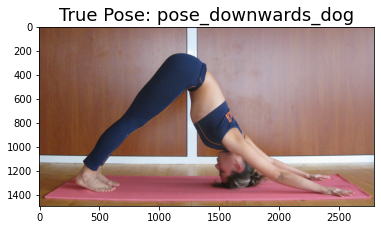

cos_similarity_vals [(-0.35826260779622743, 'pose_crescent_lunge'), (0.10041290472639572, 'pose_camel'), (-0.27828735928334664, 'pose_warrior'), (-0.17412487301412793, 'pose_extended_triangle'), (0.7821502599244246, 'pose_downwards_dog')]
0.7821502599244246 pose_downwards_dog
weighted_cos_similarity_vals [(-0.2903827181767124, 'pose_crescent_lunge'), (0.006618498539257359, 'pose_camel'), (-0.27797968153265984, 'pose_warrior'), (-0.08412952859881885, 'pose_extended_triangle'), (0.6096006203681088, 'pose_downwards_dog')]
0.6096006203681088 pose_downwards_dog
euclidean_distance_vals [(1.120198883329201, 'pose_crescent_lunge'), (0.7663707468353951, 'pose_camel'), (1.0107866131367487, 'pose_warrior'), (0.9786226644206626, 'pose_extended_triangle'), (0.29476428733873766, 'pose_downwards_dog')]
0.29476428733873766 pose_downwards_dog
euclidean_distance threshold met
Prediction is True
Predicted: pose_downwards_dog vs True: pose_downwards_dog


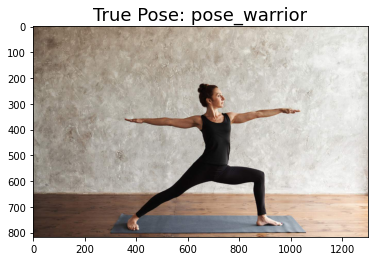

cos_similarity_vals [(0.8492621395218253, 'pose_crescent_lunge'), (0.17789686154738577, 'pose_camel'), (0.9832951261531302, 'pose_warrior'), (0.37229173514565406, 'pose_extended_triangle'), (-0.2616035488506567, 'pose_downwards_dog')]
0.9832951261531302 pose_warrior
weighted_cos_similarity_vals [(0.8468595317098734, 'pose_crescent_lunge'), (0.17735522742771268, 'pose_camel'), (0.9805646126614858, 'pose_warrior'), (0.370424183703608, 'pose_extended_triangle'), (-0.2624838756072286, 'pose_downwards_dog')]
0.9805646126614858 pose_warrior
euclidean_distance_vals [(0.3440640639959282, 'pose_crescent_lunge'), (0.738525113959818, 'pose_camel'), (0.09337497098705685, 'pose_warrior'), (0.7141782805325144, 'pose_extended_triangle'), (1.0356723847701947, 'pose_downwards_dog')]
0.09337497098705685 pose_warrior
euclidean_distance threshold met
Prediction is True
Predicted: pose_warrior vs True: pose_warrior


In [14]:
base_pose_dir = "inputs/yoga_poses/"
available_pose_names = get_valid_pose_folder_names(folder_dir)

input_img_paths = ["inputs/yoga_poses/test_poses/downward_facing_dog.JPG", "inputs/yoga_poses/test_poses/warrior.jpg"]
true_poses = ["pose_downwards_dog", "pose_warrior"]

for input_image_path, true_pose in zip(input_img_paths, true_poses):
    input_img = cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB)
    plt.title(f"True Pose: {true_pose}", fontsize=18)
    plt.imshow(input_img)
    plt.show()

    input_landmark_pose_df = generate_pose_landmarks(input_img)
    
    pose_scoring_dict = {}

    for pose_name in available_pose_names:
        if pose_name not in pose_scoring_dict:
            pose_scoring_dict[pose_name] = {
                'cos_similarity': [],
                'weighted_cos_similarity': [],
                'euclidean_distance': []
            }

        single_pose_folder = os.path.join(base_pose_dir, pose_name)
        single_pose_files = os.listdir(single_pose_folder)

        for file in single_pose_files:
            if not ".csv" in file:
                continue

            curr_df = pd.read_csv(os.path.join(single_pose_folder, file))
            aggregated_similarity_metrics = calculate_similarity_metrics_from_pose_dfs(pose_a_df=input_landmark_pose_df, pose_b_df=curr_df)
            diff_dict = get_metric_mean_differences(aggregated_similarity_metrics, plot=False)
            # print("diff_dict", diff_dict)

            pose_scoring_dict[pose_name]["cos_similarity"].append(diff_dict["cos_similarity"])
            pose_scoring_dict[pose_name]["weighted_cos_similarity"].append(diff_dict["weighted_cos_similarity"])
            pose_scoring_dict[pose_name]["euclidean_distance"].append(diff_dict["euclidean_distance"])


    # Calc aggregate scores
    agg_means = {}
    for pose, data in pose_scoring_dict.items():
        agg_means[pose] = {}

        for metric, arr in data.items():
            agg_means[pose][metric] = np.mean(arr)

    predicted_pose = identify_best_pose(agg_means)
    
    print(f"Prediction is {predicted_pose==true_pose}")
    print(f"Predicted: {predicted_pose} vs True: {true_pose}")
    
    

## Results

It works!

Issues...
- Algorithm invariant to flips, look into normalising images via transformations??
- Or just flip images when we compare and take the best fit results independent of which direction the flip occurs in

In [8]:
# image_path = "inputs/yoga_poses/pose_downwards_dog/3.png"

# image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
# plt.imshow(image)
# plt.show()

# image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
# flip_image = cv2.flip(image, 1)

# plt.imshow(flip_image)
# plt.show()


# # Make fake CSV
# # with mp_holistic.Holistic(
# #     static_image_mode=True, min_detection_confidence=0.75, model_complexity=2, 
# # ) as pose:
        
# #     image_path = "inputs/yoga_poses/pose_downwards_dog/3.png"

# #     pose_dir = os.path.dirname(image_path)
# #     base_name = os.path.splitext(os.path.basename(image_path))[0]
# #     image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
# #     image = cv2.flip(image, 1)

# #     results = pose.process(image)

# #     landmark_body_arr = []
# #     for i, landmark in enumerate(results.pose_world_landmarks.landmark):
# #         body_part = index_to_body_mapping[i]
# #         landmark_body_arr.append([body_part, landmark.x, landmark.y, landmark.z, landmark.visibility])

# #     columns = ["pose_landmark", "x", "y", "z", "visibility"]
# #     landmark_pose_df = pd.DataFrame(data=landmark_body_arr, columns=columns)
# #     landmark_pose_df.to_csv(os.path.join(pose_dir, f"FLIP_{base_name}_landmarks_holistic_0-75_2.csv"), index=False)    
    
# # landmark_pose_df